In [1]:
# neural style transfer structure
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision as tv




device = 'cuda' if torch.cuda.is_available() else 'cpu' 




def getimage(image_path,image_size=(512,512)):
    transform = tv.transforms.Compose([
            tv.transforms.Resize(image_size),
            tv.transforms.ToTensor(),
            ])
    img = Image.open(image_path).convert('RGB')
    img = transform(img)
    img = img[None,:,:,:]
    return img.to(device, torch.float)




def myimshow(image, title,save=False,ax=plt):  
    fig=plt.figure()  
    image = image.squeeze(0) 
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    h = ax.imshow(image) 
    ax.title(title)
    ax.axis('off') 
    
    if save:
        fig.savefig('{}.jpg'.format(title))
    return h,image

class NormalizeModule(nn.Module):
    def __init__(self):
        super(NormalizeModule, self).__init__()
        self.mean = torch.tensor([0.5, 0.5, 0.5]).view(-1, 1, 1).to(device)
        self.std = torch.tensor([0.5, 0.5, 0.5]).view(-1, 1, 1).to(device)

    def forward(self, x):
        f = (x - self.mean) / self.std
        return f


class ClossModule(nn.Module):

    def __init__(self, f_content,):
        super(ClossModule, self).__init__()
        self.f_content = f_content.detach()

    def forward(self, x):
        self.loss = F.mse_loss(x, self.f_content)/2
        return x

def gram_matrix(x):
        B, N, W, H = x.size()  
        f = x.view(B*N, W*H)  
        G = torch.mm(f, f.t())/(2*B*N*W*H)  
        return G


class SlossModule(nn.Module):

    def __init__(self, f_style):
        super(SlossModule, self).__init__()
        self.G_style = gram_matrix(f_style).detach()

    def forward(self, x):
        G_input = gram_matrix(x)
        self.loss = F.mse_loss(G_input, self.G_style)
        return x




def getmodel(style_img, content_img,content_layers,style_layers):
    
    vgg = tv.models.vgg19(pretrained=True).features.to(device)
    
    model = nn.Sequential()
    model.add_module('Normalization', NormalizeModule().to(device))

    i = 0  
    j = 0
    m = 0
    n = 0
    for layer in vgg:
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'Conv_{}'.format(i)
        else:
            if isinstance(layer, nn.ReLU):
                layer = nn.ReLU(inplace=False)
            j += 1
            name = 'Notconv_{}'.format(j)

        model.add_module(name, layer)

        if name[5:] in str(content_layers):
            m += 1
            f_content = model(content_img).detach()
            Closs = ClossModule(f_content)
            model.add_module("Closs_{}".format(m), Closs)
          

        if name[5:] in str(style_layers):
            n += 1
            f_style = model(style_img).detach()
            Sloss = SlossModule(f_style)
            model.add_module("Sloss_{}".format(n), Sloss)
            
        if m==len(content_layers) and n==len(style_layers):
            break
    return model



def nst(input_img,content_img, style_img,
                       content_layers,style_layers,
                       style_weight=1000000, content_weight=1,tol=np.inf,T=3000,lr=0.001):
    
    model = getmodel(style_img, content_img,content_layers,style_layers)
    optimizer = torch.optim.Adam([input_img.requires_grad_()],lr=lr)
    n_active=len(style_layers)
    epoch=0
    running_loss=np.inf
    while epoch<T or running_loss>tol:
        optimizer.zero_grad()
        model(input_img)
        style_loss = 0
        content_loss = 0

        for name, module in model.named_children():
            if 'Sloss' in name:
                style_loss += module.loss
            if 'Closs' in name:
                content_loss += module.loss

        loss = style_weight*style_loss/n_active+ content_weight*content_loss
        loss.backward()

        optimizer.step()
        
        epoch += 1
        running_loss = loss.item()
        if epoch % 300 == 299:
            print("epoch : {}:".format(epoch+1))
            print('Weighted Loss : {}'.format(running_loss))

    input_img.data.clamp_(0, 1)
    return input_img


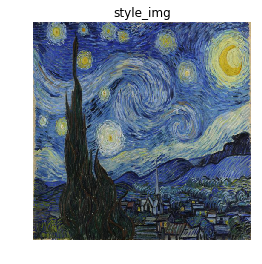

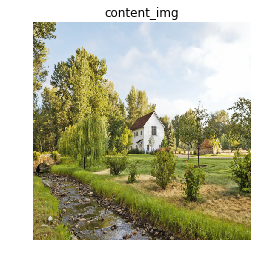

In [2]:
style_img = getimage('starry.jpg')
content_img = getimage('house.jpg')
_,_=myimshow(style_img,'style_img')
_,_=myimshow(content_img,'content_img')

In [3]:
content_layers_0 = [4]
style_layers_1= [1]
style_layers_2= [1,2]
style_layers_3= [1,2,3]
style_layers_4 = [1,2,3,4]

## Considering style features from Conv_1 layer

In [4]:
input_img = torch.rand(content_img.shape).to(device)*.1+content_img.clone()*.9

epoch : 300:
Weighted Loss : 0.38720279932022095
epoch : 600:
Weighted Loss : 0.12173525243997574
epoch : 900:
Weighted Loss : 0.07052656263113022
epoch : 1200:
Weighted Loss : 0.05820506811141968
epoch : 1500:
Weighted Loss : 0.0520947203040123
epoch : 1800:
Weighted Loss : 0.04812350869178772
epoch : 2100:
Weighted Loss : 0.0453425832092762
epoch : 2400:
Weighted Loss : 0.04327461123466492
epoch : 2700:
Weighted Loss : 0.04166838526725769
epoch : 3000:
Weighted Loss : 0.040361955761909485


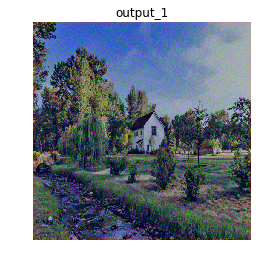

In [5]:
output_1_exp1 = nst(input_img,content_img, style_img,
             content_layers=content_layers_0,style_layers=style_layers_1,
              style_weight=1000000, content_weight=1)

_,op1=myimshow(output_1_exp1.detach(),'output_1',save=True)


## Considering style features from Conv_1 and Conv_2.

In [6]:
input_img = torch.rand(content_img.shape).to(device)*.1+content_img.clone()*.9

epoch : 300:
Weighted Loss : 0.546161949634552
epoch : 600:
Weighted Loss : 0.35148105025291443
epoch : 900:
Weighted Loss : 0.23219868540763855
epoch : 1200:
Weighted Loss : 0.1661856472492218
epoch : 1500:
Weighted Loss : 0.13450360298156738
epoch : 1800:
Weighted Loss : 0.11894413828849792
epoch : 2100:
Weighted Loss : 0.11041972786188126
epoch : 2400:
Weighted Loss : 0.10491663962602615
epoch : 2700:
Weighted Loss : 0.10093782842159271
epoch : 3000:
Weighted Loss : 0.09787295013666153


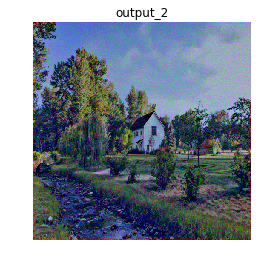

In [7]:
output_2_exp1 = nst(input_img,content_img, style_img,
             content_layers=content_layers_0,style_layers=style_layers_2,
              style_weight=1000000, content_weight=1)

_,op2=myimshow(output_2_exp1.detach(),'output_2',save=True)

## Considering style features from Conv_1, Conv_2 and Conv_3.

In [8]:
input_img = torch.rand(content_img.shape).to(device)*.1+content_img.clone()*.9

epoch : 300:
Weighted Loss : 1.455570101737976
epoch : 600:
Weighted Loss : 0.9190161228179932
epoch : 900:
Weighted Loss : 0.749582052230835
epoch : 1200:
Weighted Loss : 0.6570149660110474
epoch : 1500:
Weighted Loss : 0.5904067754745483
epoch : 1800:
Weighted Loss : 0.5349807739257812
epoch : 2100:
Weighted Loss : 0.48860472440719604
epoch : 2400:
Weighted Loss : 0.45064085721969604
epoch : 2700:
Weighted Loss : 0.41975611448287964
epoch : 3000:
Weighted Loss : 0.3950752913951874


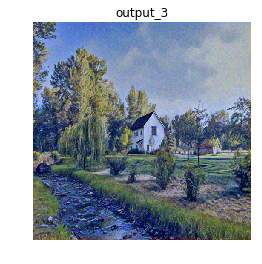

In [9]:
output_3_exp1 = nst(input_img,content_img, style_img,
             content_layers=content_layers_0,style_layers=style_layers_3,
              style_weight=1000000, content_weight=1)

_,op3=myimshow(output_3_exp1.detach(),'output_3',save=True)

## Considering style features from Conv_1, Conv_2, Conv_3 and Conv_4. 

In [10]:
input_img = torch.rand(content_img.shape).to(device)*.1+content_img.clone()*.9

epoch : 300:
Weighted Loss : 1.8878637552261353
epoch : 600:
Weighted Loss : 1.1311790943145752
epoch : 900:
Weighted Loss : 0.9401216506958008
epoch : 1200:
Weighted Loss : 0.8485479950904846
epoch : 1500:
Weighted Loss : 0.7900816798210144
epoch : 1800:
Weighted Loss : 0.7450279593467712
epoch : 2100:
Weighted Loss : 0.7066783905029297
epoch : 2400:
Weighted Loss : 0.6737330555915833
epoch : 2700:
Weighted Loss : 0.645626425743103
epoch : 3000:
Weighted Loss : 0.6214641332626343


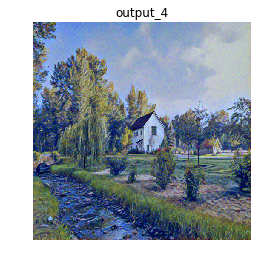

In [11]:
output_4_exp1 = nst(input_img,content_img, style_img,
             content_layers=content_layers_0,style_layers=style_layers_4,
              style_weight=1000000, content_weight=1)

_,op4=myimshow(output_4_exp1.detach(),'output_4',save=True)

Text(0.5, 1.0, 'Conv_1,2,3,4')

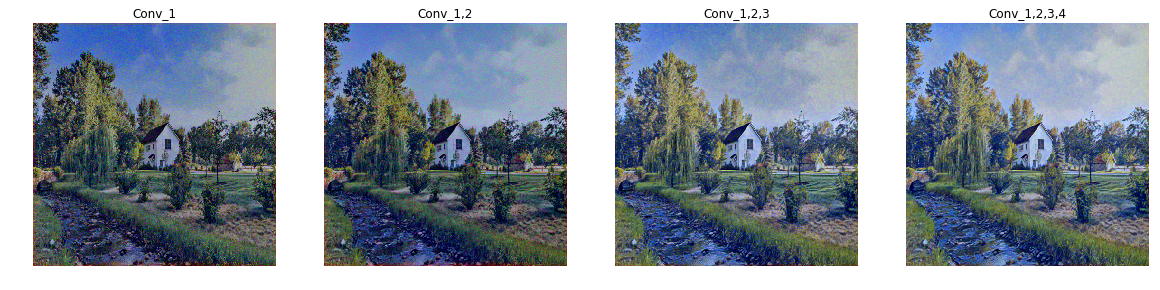

In [13]:
fig, axes = plt.subplots(ncols=4, figsize=(20,20),sharex='all' ,sharey='all')
axes[0].imshow(op1) 
axes[0].axis('off') 
axes[0].set_title('Conv_1') 
axes[1].imshow(op2) 
axes[1].axis('off') 
axes[1].set_title('Conv_1,2')
axes[2].imshow(op3) 
axes[2].axis('off') 
axes[2].set_title('Conv_1,2,3')
axes[3].imshow(op4) 
axes[3].axis('off') 
axes[3].set_title('Conv_1,2,3,4')